In [1]:
!nvidia-smi

Sun Sep 10 11:46:05 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8               1W /  95W |   1356MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


torch.cuda.amp.autocast(enabled=False)

# REPRODUCE
torch.backends.cudnn.deterministi=True
random.seed(hash('setting random seeds')% 2**32-1)
np.random.seed(hash('improves reproducibility')%2**32-1)
torch.manual_seed(hash("by removing stochasticity")%2**32-1)
torch.cuda.manual_seed_all(hash('so runs are repetable')%2**32-1)

In [3]:
from utils import cuda,device,show__random_img

In [4]:
train_transforms = transforms.Compose([
    # transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    # transforms.Resize((28, 28)),
    # transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [5]:
train_data = datasets.MNIST('../data', train=True, download=False, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=False, transform=test_transforms)

In [6]:
batch_size = 64

if torch.cuda.is_available():
    kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 3, 'pin_memory': True}
else:
    kwargs = {'batch_size':32,'shuffle':True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [7]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

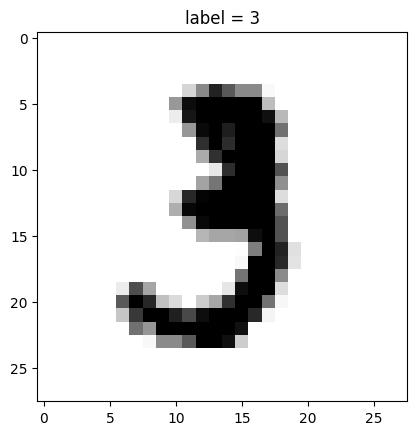

In [8]:
for i in random.choices(np.arange(0,20),k=1):
    plt.imshow(train_data.data[i],cmap='binary')
    plt.title(f'label = {train_data.targets[i].numpy()}')
    plt.show()

### Model 1

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        DROPOUT=0.0
        self.conv1 = nn.Sequential(

            nn.Conv2d(in_channels=1,out_channels=3,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Dropout2d(p=DROPOUT),

            nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(p=DROPOUT),
            
            nn.Conv2d(in_channels=8,out_channels=10,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(p=DROPOUT),
        )
        self.trans1 = nn.Sequential(

            nn.MaxPool2d( kernel_size =2 , stride =2 , padding =1 ),
            nn.Conv2d(in_channels=10,out_channels=8,kernel_size=1,bias=False,padding=1),
            nn.BatchNorm2d(8),

        )

        self.conv2 =nn.Sequential(
            nn.Conv2d(in_channels=8,out_channels=10,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout2d(p=DROPOUT),

            nn.Conv2d(in_channels=10,out_channels=12,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout2d(p=DROPOUT),

            nn.Conv2d(in_channels=12,out_channels=12,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout2d(p=DROPOUT),
        )
        self.trans2 = nn.Sequential(
            nn.MaxPool2d( kernel_size =2 , stride =2 , padding =1 ),
            nn.Conv2d(in_channels=12,out_channels=8,kernel_size=1,bias=False),
            nn.BatchNorm2d(8),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8,out_channels=12,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout2d(p=DROPOUT),
            
            nn.Conv2d(in_channels=12,out_channels=12,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout2d(p=DROPOUT),

        )
        self.trans3 = nn.Sequential(
            nn.MaxPool2d( kernel_size =2 , stride =2 , padding =0 ),
            nn.Conv2d(in_channels=12,out_channels=10,kernel_size=1,bias=False),
            nn.BatchNorm2d(10),
        )

        self.out4 = nn.Sequential(
            nn.Conv2d(in_channels=10 ,out_channels=10, kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(10),
            nn.AvgPool2d(kernel_size=3)  #(1*1*10)
        )


    def forward(self,x):
        x = self.trans1( self.conv1(x) )
        x = self.trans2( self.conv2(x) )
        x = self.trans3( self.conv3(x) )
        x = self.out4(x)
        x = x.view(-1,10)
        return F.log_softmax(x,dim=1)


In [10]:
model = Net().to(device)
for name,weights in model.named_parameters():
    print(f"{name}\t\t {weights.shape}")

summary(model=model,input_size=(1,28,28),device='cuda');

optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
criterion =  F.nll_loss
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

conv1.0.weight		 torch.Size([3, 1, 3, 3])
conv1.1.weight		 torch.Size([3])
conv1.1.bias		 torch.Size([3])
conv1.4.weight		 torch.Size([8, 3, 3, 3])
conv1.5.weight		 torch.Size([8])
conv1.5.bias		 torch.Size([8])
conv1.8.weight		 torch.Size([10, 8, 3, 3])
conv1.9.weight		 torch.Size([10])
conv1.9.bias		 torch.Size([10])
trans1.1.weight		 torch.Size([8, 10, 1, 1])
trans1.2.weight		 torch.Size([8])
trans1.2.bias		 torch.Size([8])
conv2.0.weight		 torch.Size([10, 8, 3, 3])
conv2.1.weight		 torch.Size([10])
conv2.1.bias		 torch.Size([10])
conv2.4.weight		 torch.Size([12, 10, 3, 3])
conv2.5.weight		 torch.Size([12])
conv2.5.bias		 torch.Size([12])
conv2.8.weight		 torch.Size([12, 12, 3, 3])
conv2.9.weight		 torch.Size([12])
conv2.9.bias		 torch.Size([12])
trans2.1.weight		 torch.Size([8, 12, 1, 1])
trans2.2.weight		 torch.Size([8])
trans2.2.bias		 torch.Size([8])
conv3.0.weight		 torch.Size([12, 8, 3, 3])
conv3.1.weight		 torch.Size([12])
conv3.1.bias		 torch.Size([12])
conv3.4.weight		 torc

Train: Loss=0.1142 Batch_id=937 Accuracy=94.60: 100%|████████████| 938/938 [00:18<00:00, 51.54it/s]


Test set: Average loss: 0.0725, Accuracy: 9773/10000 (97.7300%)

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 2


Train: Loss=0.0695 Batch_id=937 Accuracy=97.94: 100%|████████████| 938/938 [00:18<00:00, 51.34it/s]


Test set: Average loss: 0.0492, Accuracy: 9840/10000 (98.4000%)

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 3


Train: Loss=0.0756 Batch_id=937 Accuracy=98.35: 100%|████████████| 938/938 [00:18<00:00, 51.46it/s]


Test set: Average loss: 0.0524, Accuracy: 9831/10000 (98.3100%)

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 4


Train: Loss=0.0314 Batch_id=937 Accuracy=98.61: 100%|████████████| 938/938 [00:20<00:00, 45.39it/s]


Test set: Average loss: 0.0357, Accuracy: 9892/10000 (98.9200%)

Adjusting learning rate of group 0 to 2.0000e-01.
Epoch 5


Train: Loss=0.0049 Batch_id=937 Accuracy=98.79: 100%|████████████| 938/938 [00:18<00:00, 49.48it/s]


Test set: Average loss: 0.0557, Accuracy: 9814/10000 (98.1400%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 6


Train: Loss=0.0347 Batch_id=937 Accuracy=99.21: 100%|████████████| 938/938 [00:18<00:00, 50.36it/s]


Test set: Average loss: 0.0225, Accuracy: 9923/10000 (99.2300%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 7


Train: Loss=0.0105 Batch_id=937 Accuracy=99.34: 100%|████████████| 938/938 [00:19<00:00, 48.72it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.3300%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 8


Train: Loss=0.1160 Batch_id=937 Accuracy=99.36: 100%|████████████| 938/938 [00:20<00:00, 45.90it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.3000%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 9


Train: Loss=0.0175 Batch_id=937 Accuracy=99.41: 100%|████████████| 938/938 [00:19<00:00, 48.18it/s]


Test set: Average loss: 0.0223, Accuracy: 9924/10000 (99.2400%)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 10


Train: Loss=0.0115 Batch_id=937 Accuracy=99.44: 100%|████████████| 938/938 [00:20<00:00, 46.10it/s]


Test set: Average loss: 0.0226, Accuracy: 9925/10000 (99.2500%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 11


Train: Loss=0.0028 Batch_id=937 Accuracy=99.48: 100%|████████████| 938/938 [00:20<00:00, 46.29it/s]


Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.2800%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 12


Train: Loss=0.0296 Batch_id=937 Accuracy=99.48: 100%|████████████| 938/938 [00:20<00:00, 46.63it/s]


Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.2800%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 13


Train: Loss=0.0063 Batch_id=937 Accuracy=99.48: 100%|████████████| 938/938 [00:20<00:00, 44.89it/s]


Test set: Average loss: 0.0220, Accuracy: 9925/10000 (99.2500%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 14


Train: Loss=0.0024 Batch_id=937 Accuracy=99.48: 100%|████████████| 938/938 [00:20<00:00, 45.35it/s]


Test set: Average loss: 0.0220, Accuracy: 9925/10000 (99.2500%)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch 15


Train: Loss=0.0032 Batch_id=937 Accuracy=99.48: 100%|████████████| 938/938 [00:20<00:00, 45.39it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.3200%)

Adjusting learning rate of group 0 to 2.0000e-04.


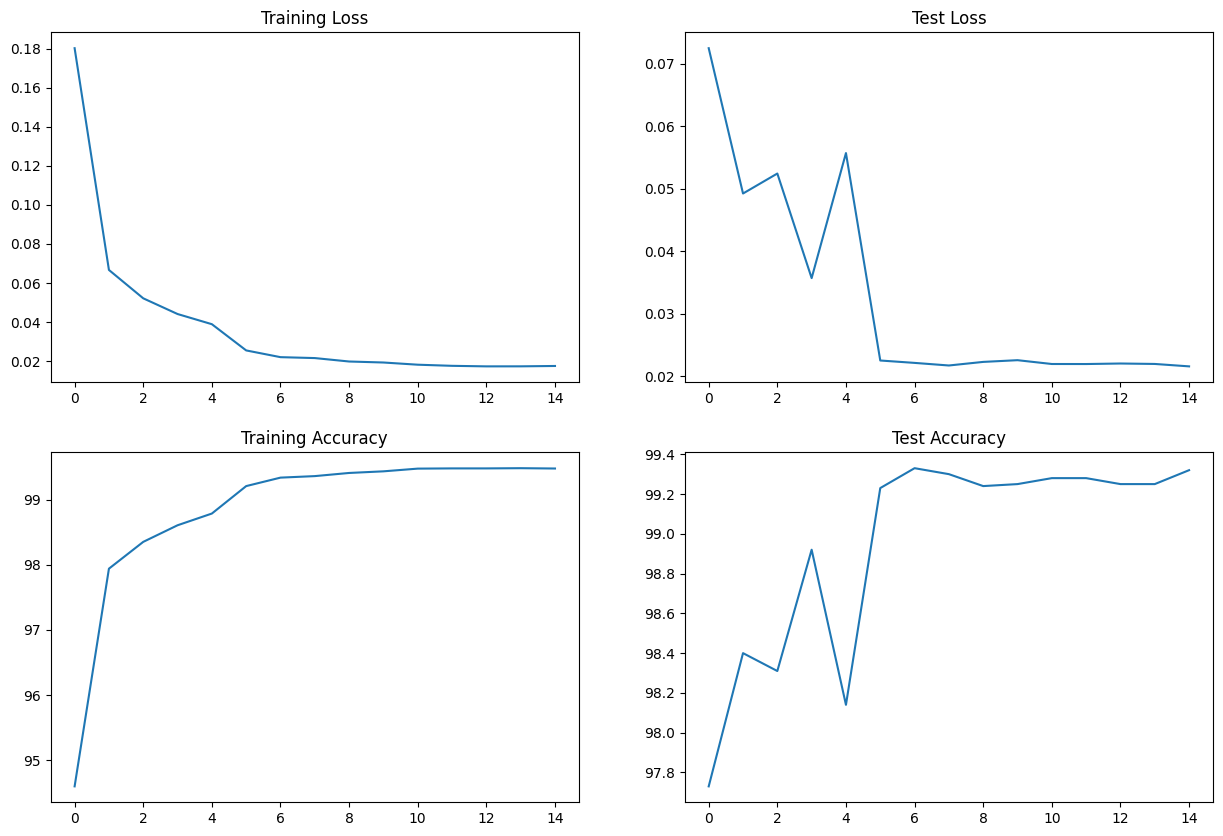

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [12]:
from utils import calculate_mean_std_mnist
mnist_data = datasets.MNIST( root='../data', download=False, transform=transforms.ToTensor() ,)
mean,std= calculate_mean_std_mnist(mnist_data)

print(mean,std)

0.13065974414348602 0.3015038073062897
